In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='CAG')|(df['Sub-task A']=='OAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
  return df

In [3]:
train_df=load_csv("/content/drive/My Drive/eng_train.csv")
dev_df=load_csv("/content/drive/My Drive/eng_dev.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0                                          Next part           0
1                 Iii8mllllllm\nMdxfvb8o90lplppi0005           0
2  🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...           0
3  What the fuck was this? I respect shwetabh and...           0
4  Concerned authorities should bring arundathi R...           0
                                                Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0


In [4]:
train_df.shape,dev_df.shape

((4263, 2), (1066, 2))

In [5]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    3375
1     453
2     435
Name: Sub-task A, dtype: int64
0    836
1    117
2    113
Name: Sub-task A, dtype: int64


In [6]:
from keras.preprocessing.text import one_hot
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in train_df['Text']]
print (encoded_docs)
encoded_docs2=[one_hot(d,vocab_size) for d in dev_df['Text']]
print (encoded_docs2)

[[2793474, 1615109], [1503311, 2752487], [2238621, 2651842, 1647348, 381986, 1554976, 1416924, 744565, 97250, 1132255, 2104933], [1642765, 2458162, 3127960, 3670188, 2104933, 1742707, 1927161, 2627271, 2630167, 1742707, 144673, 3265001, 3632347, 1742413, 2096036, 760811, 2329556, 1655654, 3821049, 2538992, 2108132, 2104933, 2242506, 3670188, 1038435, 1290508, 1227382, 2541520, 3771114, 2458162, 94299, 760811, 1287962, 450996, 890408, 2710604, 2443739, 3771114, 2326519, 760811, 2091263, 2710604, 3480048, 294144, 32189, 2172701, 2630167, 3443315, 523009, 3522510, 3070737, 1107050, 2597460, 3629636, 604952, 480664, 1152932, 2630167, 3311043, 2171062, 3360633, 3179807, 2108132, 2858463, 89729, 1026152, 1205947, 1147599, 2104933, 94299, 1300200, 971847, 1655654, 3173594, 2630167, 2710604, 2443739, 3960656, 2541520, 2463767, 959391, 383070, 760811, 2597460, 1287962, 1038435, 2630167, 862899, 3954700, 3625278, 1440855, 1287962, 2630167, 469713, 2524803, 2630167, 1852035, 3600316, 878376, 2630

In [7]:
# pad documents to a max length of 4 words
max_length = 100
X_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(X_train)
X_test = pad_sequences(encoded_docs2, maxlen=max_length, padding='post')
print(X_test)

[[2793474 1615109       0 ...       0       0       0]
 [1503311 2752487       0 ...       0       0       0]
 [2238621 2651842 1647348 ...       0       0       0]
 ...
 [3232103 3629636  959391 ...  701684   72834  859465]
 [3762632 2554651 2270550 ...       0       0       0]
 [2083794 1907711 2541520 ...       0       0       0]]
[[3954700 1567552  744565 ...       0       0       0]
 [1759584 3418843       0 ...       0       0       0]
 [3120737  862899 1742707 ... 3465484  931493       0]
 ...
 [3196811 3954700 3885833 ...       0       0       0]
 [3639044 1742707 2863287 ...       0       0       0]
 [2710604  604952 2029412 ...       0       0       0]]


In [8]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Sub-task A']))
y_test = to_categorical(np.asarray(dev_df['Sub-task A']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(4263, 3) (1066, 3)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 8)            32000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           3200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               622848   

In [10]:
history=model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=100,batch_size=100, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4263 samples, validate on 1066 samples
Epoch 1/100





 - 17s - loss: 0.6852 - acc: 0.7793 - val_loss: 0.6262 - val_acc: 0.7842
Epoch 2/100
 - 1s - loss: 0.6113 - acc: 0.7917 - val_loss: 0.6088 - val_acc: 0.7842
Epoch 3/100
 - 1s - loss: 0.5752 - acc: 0.7922 - val_loss: 0.5858 - val_acc: 0.7852
Epoch 4/100
 - 1s - loss: 0.4856 - acc: 0.8072 - val_loss: 0.5707 - val_acc: 0.7833
Epoch 5/100
 - 1s - loss: 0.3560 - acc: 0.8487 - val_loss: 0.5977 - val_acc: 0.7767
Epoch 6/100
 - 1s - loss: 0.2697 - acc: 0.8811 - val_loss: 0.6607 - val_acc: 0.7842
Epoch 7/100
 - 1s - loss: 0.2145 - acc: 0.9087 - val_loss: 0.7975 - val_acc: 0.7871
Epoch 8/100
 - 1s - loss: 0.1805 - acc: 0.9228 - val_loss: 0.8651 - val_acc: 0.7786
Epoch 9/100
 - 1s - loss: 0.1498 - acc: 0.9392 - val_loss: 0.9216 - val_acc: 0.7636
Epoch 10/100
 - 1s - loss: 0.1185 - acc: 0.9592 - val_loss: 0.9926 - val_acc: 0.7608
Epoch 11

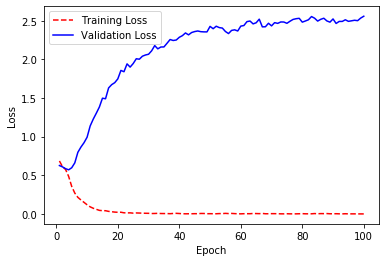

In [11]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

[2.558038453894753, 0.7579737334716611]


In [13]:
predictions_test = model.predict(X_test)
print(predictions_test)

[[1.00000000e+00 4.19597246e-09 6.50543273e-17]
 [1.00000000e+00 4.85685431e-15 2.54499719e-19]
 [1.00000000e+00 3.77890273e-22 1.59095039e-17]
 ...
 [1.00000000e+00 2.22828705e-19 1.02878345e-16]
 [1.00000000e+00 6.54085564e-13 7.98050445e-11]
 [9.99999881e-01 1.35946195e-07 9.60861682e-16]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       836
           1       0.28      0.35      0.31       117
           2       0.47      0.34      0.39       113

   micro avg       0.76      0.76      0.76      1066
   macro avg       0.54      0.52      0.52      1066
weighted avg       0.76      0.76      0.76      1066
 samples avg       0.76      0.76      0.76      1066

